<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

# Single shot Read Out 

This script uses the ....<br>


### The Signal generator is confige:<br>

 - SCLK: 6320MSas <br>
 - Segment length: 1920 points <br>
 - Channel 1 <br>
 - Sinuse wave form <br>
 - 4 points per cycle , 464 cycles, last 24 points 0 DC <br>
 - amplitude 0.5V (might be change) <br>
 - Task table define:<br>
     - 1000 Raws
     - Task 1   Enable signal = cpu
                DTrigger = on 
                Next task 1 = 2
     - Task 2-999 Trigger ADC = ON
                Next task 1 = currentTask + 1   
     - Task 1000 DTrigger = ON 
                Next task 1 = 1
       
### The Digitizer is confige:

 - Mode             : DUAL (default)<br>
 - Sample Rate      : 2.7GHz.<br>
 - DDC mode         : complex<br>
 - Trigger source   : CPU (internal)<br>
 - Center frequency :200 MHz<br>
 - Frame config     : # of frames  = 1000, Frame size = 830 <br>
 - Trigger source   : Task 1<br>


### DSP Configuration:

- IQ path input : AMPH
- Decision frame: 50 points

In [1]:
import os
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
#matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

In [3]:
# Connect to instrument
admin = TepAdmin()
    
# Get list of available PXI slots
slot_ids = admin.get_slot_ids()

# Assume that at least one slot was found
sid = slot_ids[0]

 # Open a single-slot instrument:
inst = admin.open_instrument(slot_id=sid)

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print('Connected to: ' + resp)

# Get the model name
resp = inst.send_scpi_query(":SYST:iNF:MODel?")
print("Model: " + resp)

# Infer the natural DAC waveform format
if 'P9082' in resp:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

Connected to: Tabor Electronics,P2584M,000000000000,0.0.0
Model: P2584M
DAC waveform format: 16 bits-per-point


In [6]:
# Several initializations ..

inst.default_paranoia_level = 2

inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':FREQ:RAST 6.320e9')
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


<class 'numpy.uint16'>
Segment length 1920
1920
0, no error


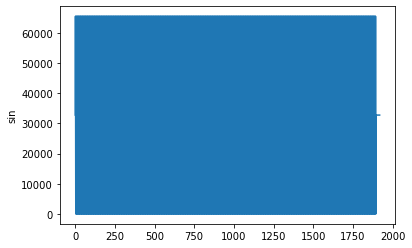

In [22]:
# Build two AWG segment that will be used as innput for the digitizer

import math
initDeg = 0
NUM_OF_CYCLES = 474
NUM_OF_SAMPLES = 4
x = np.linspace(initDeg, initDeg + 2*NUM_OF_CYCLES*math.pi-(2*math.pi)/NUM_OF_SAMPLES, NUM_OF_CYCLES*NUM_OF_SAMPLES)

x = np.concatenate((x, np.zeros(24)))
sinWave_ext = (np.sin(x) + 1.0) * half_dac
#sinWave_ext = np.concatenate((sinWave_ext, np.zeros(24)))
sinWave_ext = np.round(sinWave_ext)
sinWave_ext = np.clip(sinWave_ext, 0, max_dac)
print(data_type)
sinWave_ext = sinWave_ext.astype(data_type)

segLen = len(sinWave_ext)
print('Segment length {0}'.format(segLen))
print(segLen)

plt.figure(1)
plt.plot(sinWave_ext)
plt.ylabel('sin')

# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')


# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', sinWave_ext)

inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':OUTP ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
del sinWave_ext


# Creating Task Table 

In [23]:
tasklen = 1000

#Select channel
cmd = ':INST:CHAN 1'
inst.send_scpi_cmd(cmd )

cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
inst.send_scpi_cmd(cmd )



for i in range(tasklen):
    curr_task = i+1
    cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
    inst.send_scpi_cmd(cmd)
    cmd = ':TASK:COMP:DTRigger ON'        
    inst.send_scpi_cmd(cmd)
 
    if curr_task == 1:  
        cmd = ':TASK:COMP:ENAB CPU'
        
    if curr_task==tasklen:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
        inst.send_scpi_cmd(cmd)
    else:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
        inst.send_scpi_cmd(cmd )    

    cmd = ':TASK:COMP:TYPE SING'
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:LOOP {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:SEGM {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    
cmd = ':TASK:COMP:WRIT'
inst.send_scpi_cmd(cmd)
print('Downloading Task table to channel {0}'.format(1))

cmd = ':INST:CHAN {0}'.format(1)
inst.send_scpi_cmd(cmd)
    
cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)

cmd = 'FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


## Setup Digitizer

In [27]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')

# Set SCLK digitizer 
inst.send_scpi_cmd(':DIG:FREQ 2700MHz')

# Set DDC mode to complex
inst.send_scpi_cmd(':DIG:DDC:MODE COMPlex')

# Set center frequency of channel 1 to 200MHz
inst.send_scpi_cmd(':DIG:DDC:CFR1 200e6')

# Allocate 1000 frames of 864 samples
numframes, framelen = 1000, 864
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQuire:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

# Set Trigger AWG delay to 0
inst.send_scpi_cmd(':DIG:TRIG:DEL {0}'.format(1))

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("Set Digitizer: DUAL mode; ADC Trigger")


0, no error
Set Digitizer: DUAL mode; ADC Trigger


## Setup DSP

In [28]:
# Select to store the IQ data
inst.send_scpi_cmd(':DSP:STOR1 DSP1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Set IQ PATH Input to AMPH
inst.send_scpi_cmd(':DSP:DEC:IQP:SEL 1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
inst.send_scpi_cmd(':DSP:DEC:IQP:INP AMPH')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
# Set Decision frame size 50 points
inst.send_scpi_cmd(':DSP:DEC:FRAM {0}'.format(50))
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error
0, no error
0, no error
0, no error


## Acquire signals into Memory

In [30]:
# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')

# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')
print("Waiting to recive enter to generate trigger - press Enter to start trigger")
input()

inst.send_scpi_cmd('*TRG')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Waiting to recive enter to generate trigger - press Enter to start trigger

0, no error


## Read all frames from Memory

In [31]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


Total size in bytes: 1728000

0, no error
read data from DDR


## Plot Signals  - Need to fix, need to be x-y graph

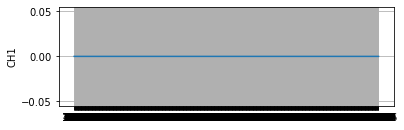

In [32]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(211)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')

plt.show()

In [ ]:
# close connection
inst.close_instrument()
admin.close_inst_admin()